In [1]:
import pyFAI
import fabio
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import os, re
from integrationFunctions import makeDataSet, makeMasks, integrateAverage, integrateIndividual


S22_001_0014p.cbf low flux, not including in averaging


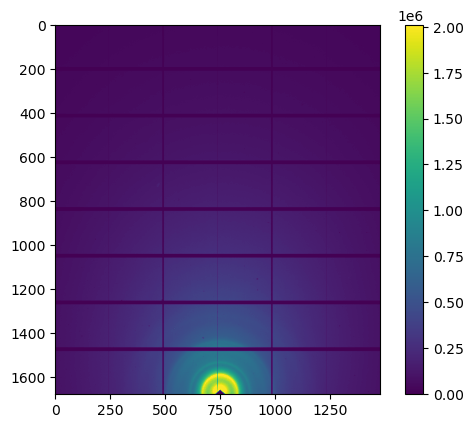

In [2]:
%matplotlib inline

direc = r'X:\staff\july2023\Julian\S22\xrd/' # Directory of xrd files
os.chdir(direc)

dest = direc.replace(r'X:\staff\july2023',r'C:\Users\kenneth1a\Documents\beamlineData\July2023')

if not os.path.exists(dest):
    os.makedirs(dest)

mask  = r'Z:\bm31\inhouse\july2023/pdf_baseMask_tilt.edf' # Mask file
mask = fabio.open(mask).data
poni  = r'Z:\bm31\inhouse\july2023/Si_15tilt_0p25579A.poni' # Poni file
poni = pyFAI.load(poni)
wavelength = poni.wavelength*10**10
gainFile = r'C:\Users\kenneth1a\Documents\beamlineData\July2023\gainmap\calculatedGainMap_48p6keV_filtered_kpm_2023-07-21.edf'

gainArray = fabio.open(gainFile).data

badFramesLog = f'{dest}/badFrames.txt'
if os.path.isfile(badFramesLog):
    os.remove(badFramesLog)

files = glob('*.cbf')
i1 = fabio.open(files[0]).data
dataset = np.empty(shape = (*i1.shape,len(files)))

doMonitor = True

#monitorfile = glob('*.dat')[0]
#monitor = np.loadtxt(monitorfile,usecols = 2, skiprows = 1)

scale = 10**9
dataset, usedFiles = makeDataSet(files, badFramesLog, scale, doMonitor)

average = np.average(dataset,axis=2)
median = np.median(dataset,axis=2)
vmax = np.percentile(np.where(np.isnan(average),0,average),99.9)
plt.figure()
plt.imshow(average,vmax = vmax)
plt.colorbar()
plt.show()

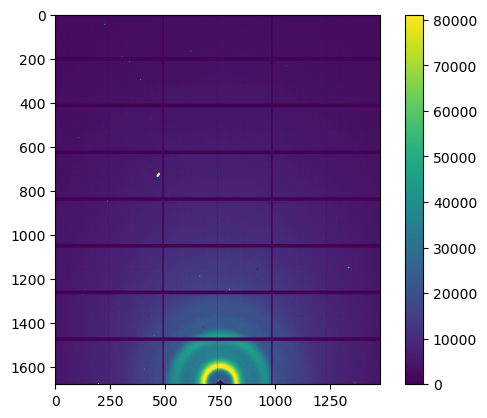

In [3]:
plt.figure()
stdev = np.std(dataset,axis = 2)
vmax = np.percentile(np.where(np.isnan(stdev),0,stdev),99.9)
plt.imshow(np.std(dataset,axis = 2),vmax = vmax)
plt.colorbar()

S22_001_0001p.cbf


<IPython.core.display.Javascript object>


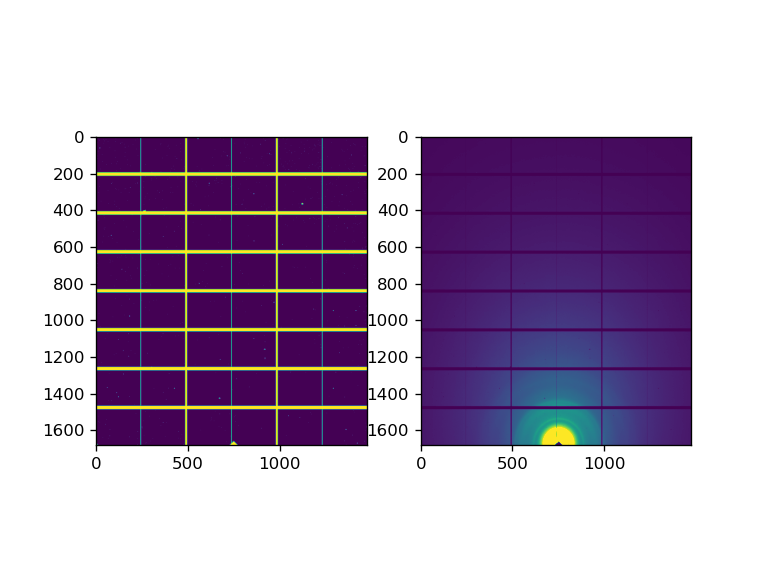

S22_001_0002p.cbf


<IPython.core.display.Javascript object>


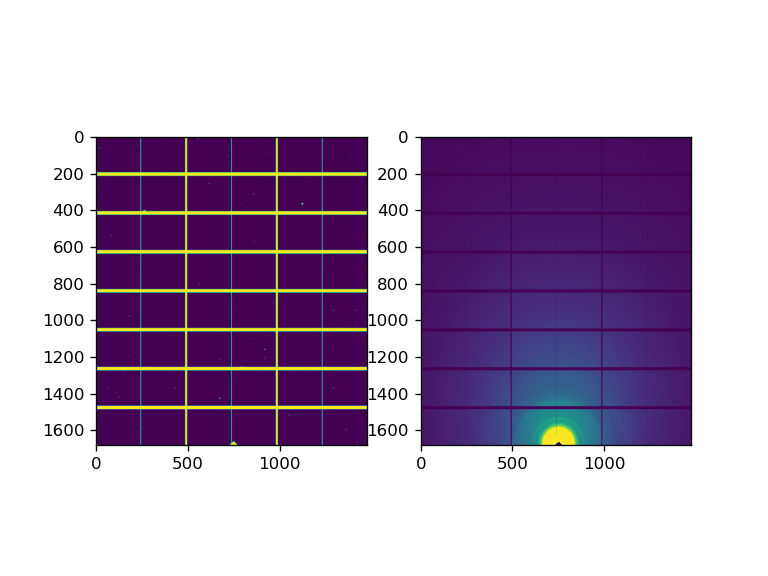

S22_001_0003p.cbf


<IPython.core.display.Javascript object>


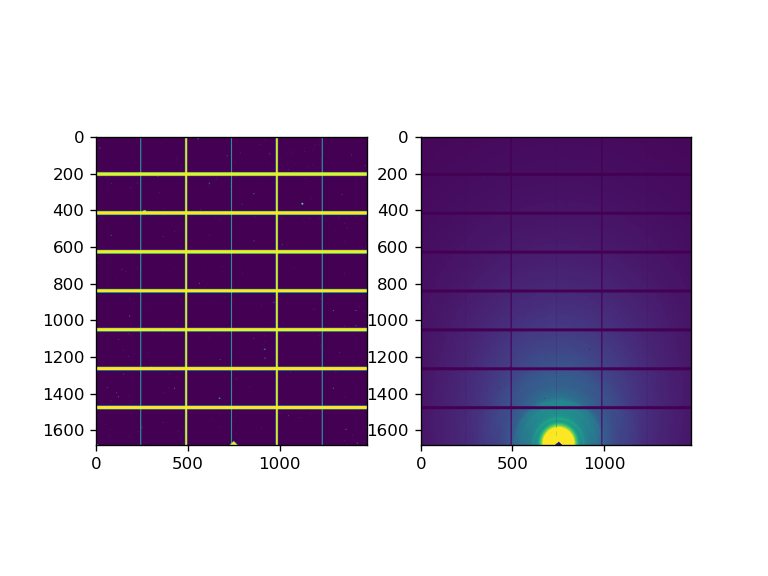

S22_001_0004p.cbf


<IPython.core.display.Javascript object>


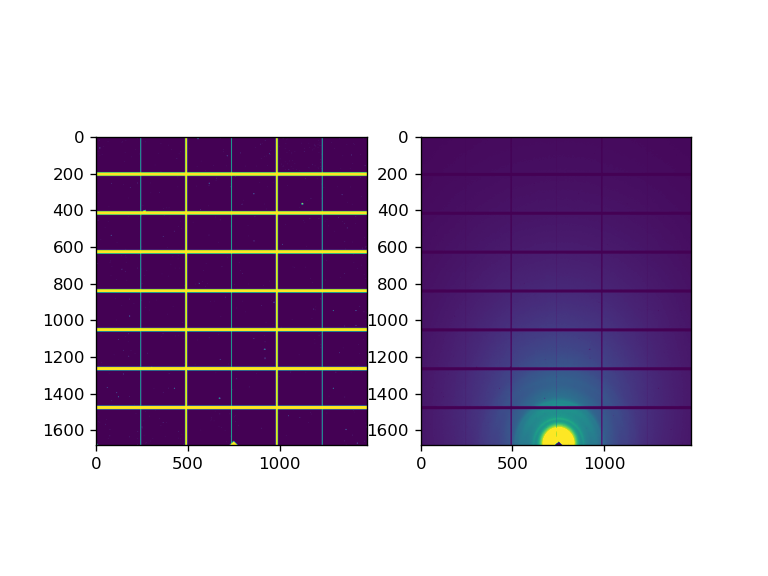

S22_001_0005p.cbf


<IPython.core.display.Javascript object>


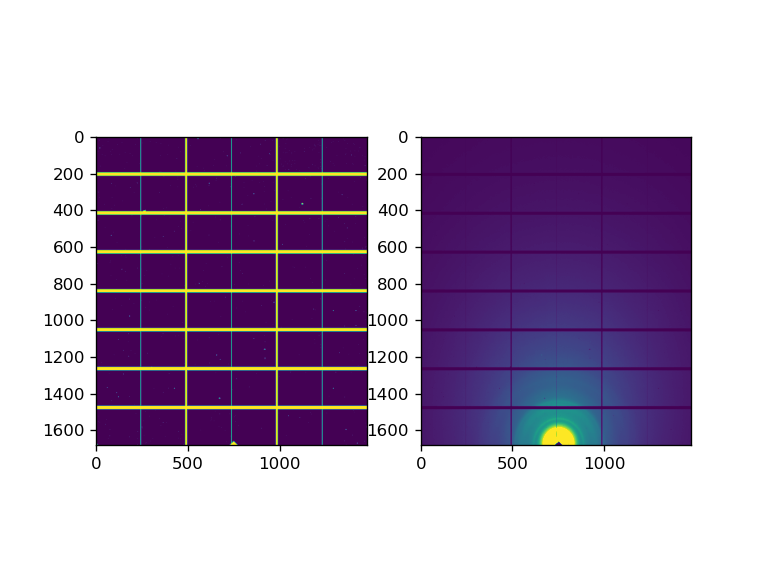

S22_001_0006p.cbf


<IPython.core.display.Javascript object>


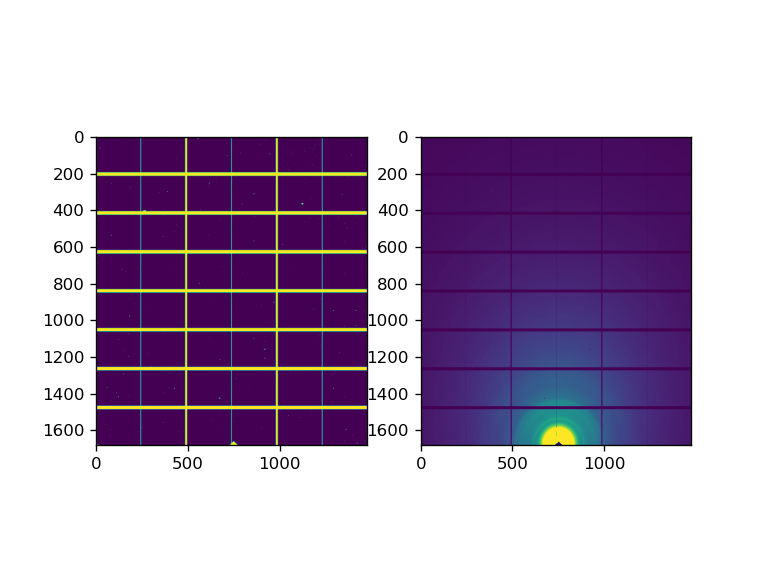

S22_001_0007p.cbf


<IPython.core.display.Javascript object>


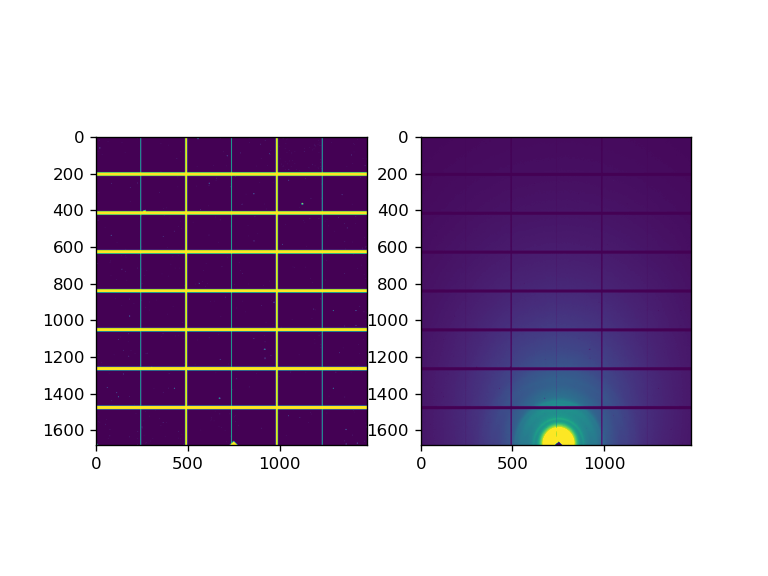

S22_001_0008p.cbf


<IPython.core.display.Javascript object>


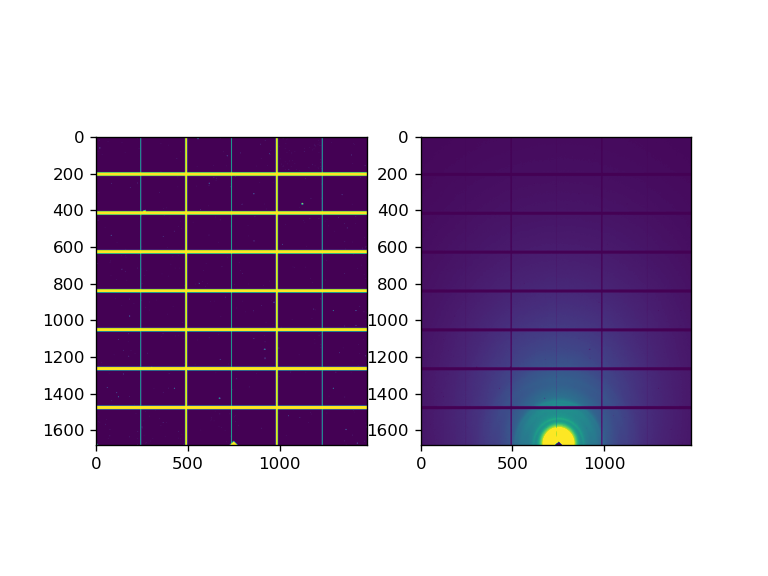

S22_001_0009p.cbf


<IPython.core.display.Javascript object>


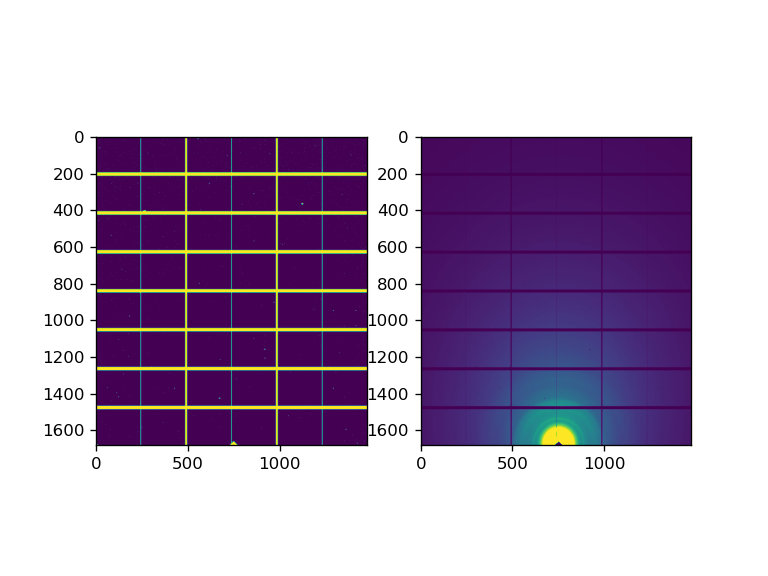

S22_001_0010p.cbf


<IPython.core.display.Javascript object>


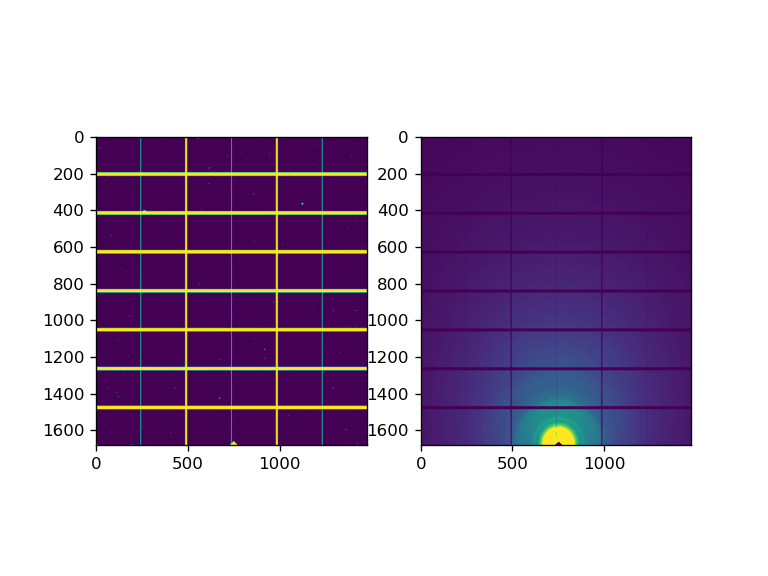

S22_001_0011p.cbf


<IPython.core.display.Javascript object>


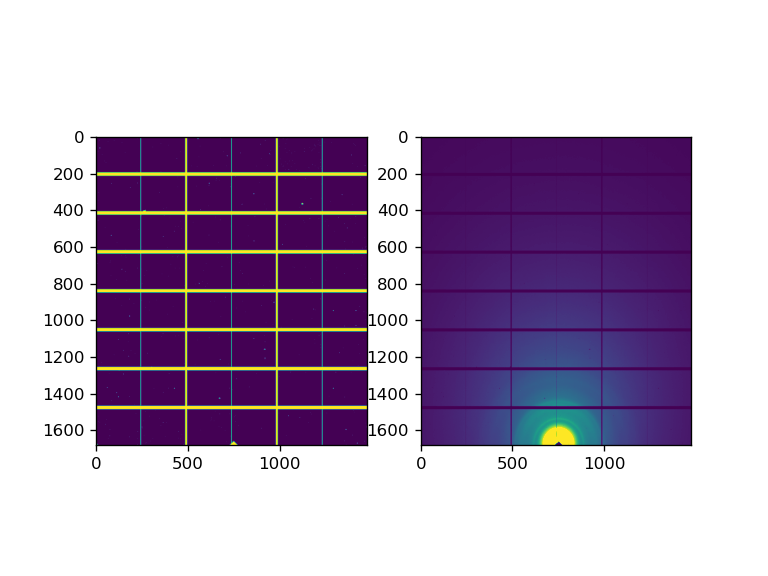

S22_001_0012p.cbf


<IPython.core.display.Javascript object>


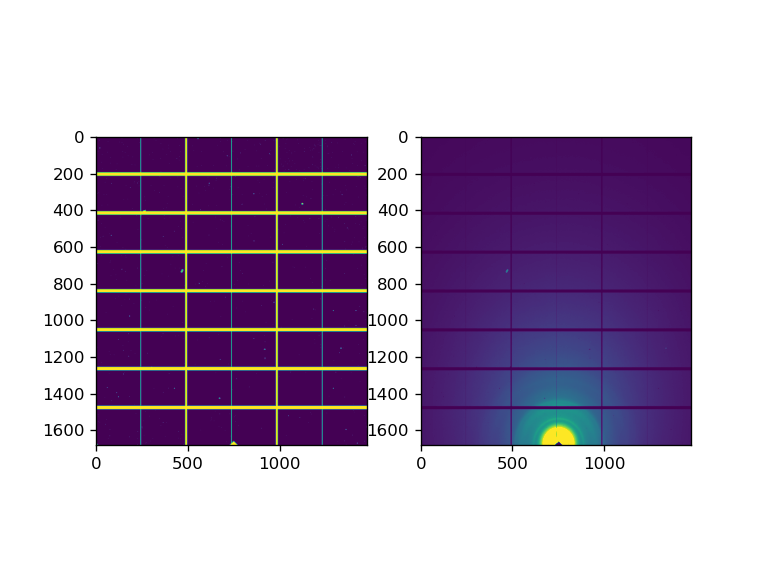

S22_001_0013p.cbf


<IPython.core.display.Javascript object>


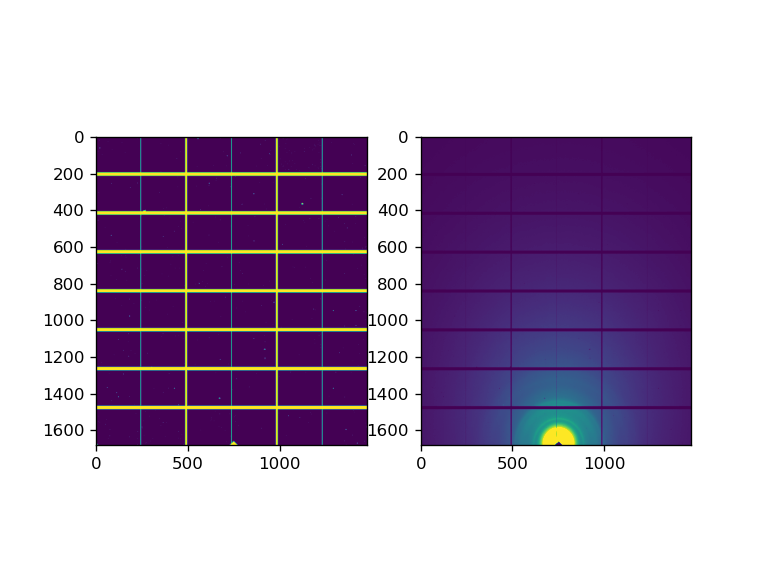

In [4]:
%matplotlib nbagg

nstdevs = 3
maskdct = makeMasks(dataset,usedFiles,mask, nstdevs = nstdevs,plot = True)

In [6]:
subdir = f'xye_{nstdevs}stdevs/'


integrateAverage(dataset, usedFiles, poni, gainArray, maskdct,dest)

integrateIndividual(dataset = dataset,files = usedFiles, dest =  dest, subdir = subdir,poni= poni, maskdct=maskdct, 
                    gainArray = gainArray)


S22_001_0001p.cbf


S22_001_0002p.cbf


S22_001_0003p.cbf


S22_001_0004p.cbf


S22_001_0005p.cbf


S22_001_0006p.cbf


S22_001_0007p.cbf


S22_001_0008p.cbf


S22_001_0009p.cbf


S22_001_0010p.cbf


S22_001_0011p.cbf


S22_001_0012p.cbf


S22_001_0013p.cbf
